# Video pipeline with Yolo + Resnet Model

In [23]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [24]:
metaseries = 1
serieses = [800, 801, 802, 803, 804]
series_metadata = {
    800: {"label": "IPA"},
    801: {"label": "FA2-low"},
    802: {"label": "FA2-high"},
    803: {"label": "RIM-low"},
    804: {"label": "RIM-high"},
}
pipeline_name = "nlp"

series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series))
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [25]:
loaders

{800: <experiments.utils.parser.AdaptationParser at 0x7f0246e84d30>,
 801: <experiments.utils.parser.AdaptationParser at 0x7f024ebfccd0>,
 802: <experiments.utils.parser.AdaptationParser at 0x7f024e6c8ee0>,
 803: <experiments.utils.parser.AdaptationParser at 0x7f024e6e5550>,
 804: <experiments.utils.parser.AdaptationParser at 0x7f0325c530d0>}

In [26]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 800 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 20,
    'gamma': 10,
    'initial_active_model': [   'dinalzein-xlm-roberta-base-finetuned-language-identification',
                                'Helsinki-NLP-opus-mt-fr-en',
                                'sshleifer-distilbart-xsum-1-1'],
    'initial_batch': [1, 1, 1],
    'initial_cpu_allocation': [1, 2, 2],
    'initial_replica': [1, 1, 1],
    'latency_margin': 0,
    'logs_enabled': True,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'mode': 'exponential',
    'model_name': ['nlp-li', 'nlp-trans', 'nlp-sum'],
    'monitoring_duration': 2,
    'nodes': [   {  

In [27]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [28]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{800: False, 801: False, 802: False, 803: False, 804: False}

In [29]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [30]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

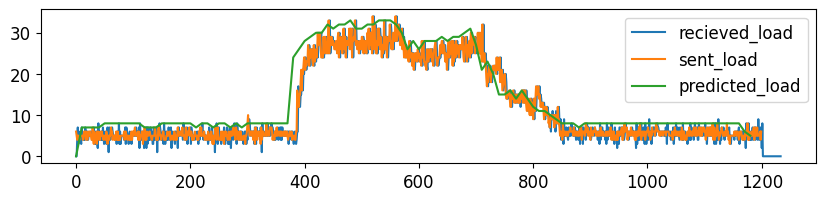

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

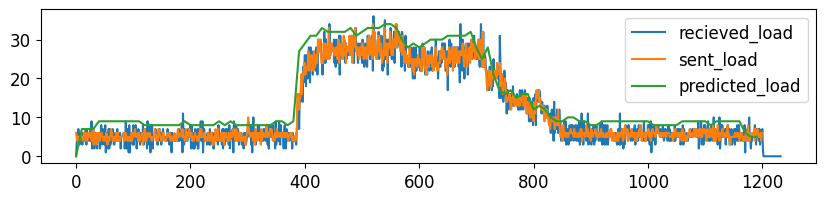

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

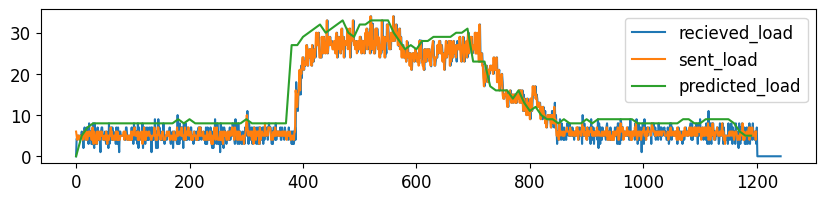

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

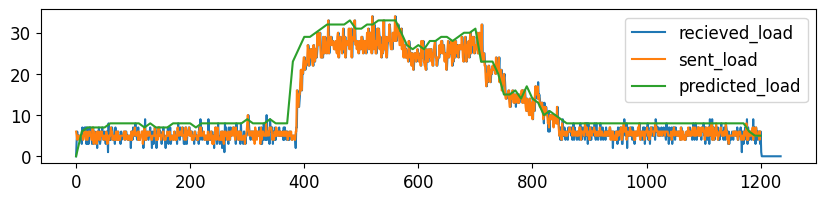

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

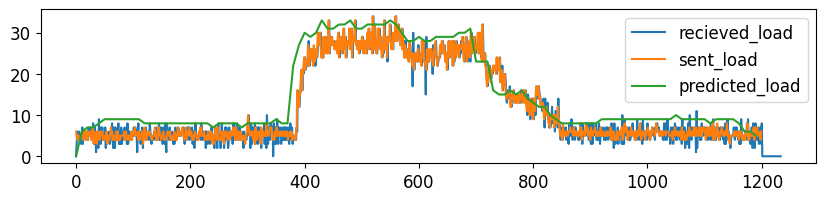

In [31]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()

## Replica Changes
1. Total
2. Per node

In [32]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [33]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [34]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())
# print(total_core_changes[221].keys())

{800: {'nlp-li': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 4, 5, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'nlp-trans': [2, 16, 16, 16, 16, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 18, 18, 18, 18, 18, 18, 16, 18, 18, 16, 18, 18, 16, 18, 16, 18, 18, 18, 18, 18, 18, 18, 18, 50, 54, 58, 60, 62, 62, 66, 64, 66, 66, 68, 64, 64, 66, 66, 68, 68, 68, 66, 62, 54, 58, 54, 58, 58, 58, 60, 58, 60, 60, 62, 64, 56, 44, 48, 42, 32, 32, 34, 30, 34, 30, 26, 24, 24, 22, 20, 18, 18, 18, 16, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18], 'nlp-sum': [2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

## Accuracy Changes

In [35]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())
# print(accuracy_changes[221].keys())

{800: {'nlp-li': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'nlp-trans': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'nlp-sum': [0.

## Maeseured p99 Latency


In [36]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [37]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
        # draw_temporal(metrics_all[series])
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())
# print(metrics_all[221].keys())

{800: {'client_to_router_p99': [0.011305546760559082, 0.006688184738159179, 0.007295494079589844, 0.006779098510742187, 0.006726961135864257, 0.006425371170043945, 0.007602517604827881, 0.009159736633300782, 0.006984968185424804, 0.00867323875427246, 0.008581387996673583, 0.00768470048904419, 0.009128808975219727, 0.007143974304199219, 0.007218384742736816, 0.00720057487487793, nan, 0.007276070117950439, 0.0073767447471618655, nan, 0.007416810989379883, 0.007653722763061524, 0.00786057710647583, 0.006995282173156738, 0.007018296718597412, 0.006024694442749024, 0.007904055118560792, 0.007099523544311524, 0.006515936851501465, 0.006817388534545899, 0.007084894180297852, 0.006947031021118164, 0.007066717147827148, 0.008019680976867675, 0.007326698303222657, 0.00731651782989502, 0.007593226432800293, 0.006939048767089844, 0.007600789070129395, 0.0073131370544433595, 0.007125518321990967, 0.007137813568115234, 0.007374310493469238, 0.007035200595855713, 0.006981515884399414, 0.0069457411766

## timeouts

In [38]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())
# print(timeout_dics[221].keys())

1077 out of 14437
122 out of 14437
11701 out of 14437
10442 out of 14437
9735 out of 14437
{800: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.926646810279144e-05, 0.0, 6.926646810279144e-05, 0.0, 0.0002770658724111658, 0.0002770658724111658, 0.0, 0.0, 0.0002770658724111658, 0.0, 0.0, 0.0003463323405139572, 0.0, 0.0, 0.0, 0.00020779940430837432, 0.0, 0.00020779940430837432, 0.0001385329362055829, 6.926646810279144e-05, 0.0001385329362055829, 6.926646810279144e-05, 0.0, 6.926646810279144e-05, 0.0, 6.926646810279144e-05, 0.0, 0.0001385329362055829, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

# Paper ready figures

In [39]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    # METRIC_TIMEOUT_DICS: {
    #     "title": "SLA Violations",
    #     "ylabel": "SLA Violations (%)",
    # },
}
results = {
    METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {},
}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

for serie in metrics_all.keys():
    latencies = list(
        filter(
            lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]
        )
    )
    results[METRIC_MEASURED_LATENCY][serie] = sum(latencies) / len(latencies)

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(
        total_core_changes[serie]["total"]
    ) / len(total_core_changes[serie]["total"])


print(results)

{'latency': {800: 3.9973214876821355, 801: 3.345340506023479, 802: 6.594508286848765, 803: 6.703651954333, 804: 5.514613933195321}, 'cost': {800: 46.2436974789916, 801: 41.775, 802: 90.4, 803: 43.04132231404959, 804: 184.71666666666667}, 'accuracy': {800: 1.6705882352941173, 801: 1.0, 802: 3.0, 803: 2.8000000000000007, 804: 2.975}}


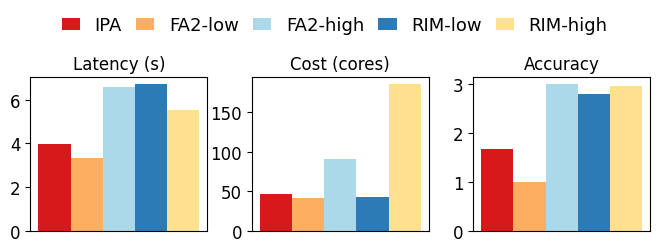

In [40]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results, series_metadata, metrics_metadata, filename=f"{FIGURES_PATH}/{pipeline_name}-cul.pdf"
)